## Drag Reduction System in Formula 1

The Drag Reduction System, or DRS, is a system that temporarily reduces the drag from the rear wing of a Formula One car. This provides the driver with a slight increase in top speed that is neccecary when he is looking to overtake another driver. The rules for when it may be used are quite strict; only in designated zones and if a driver is within one second of his rival.

It is a system of two wings. The first, larger wing is fixed in its posistion. When disabled, the second wing must maintain a gap of 10mm between itself and the closest point of the main wing. When the driver activates the DRS system, this 10mm gap is increased to 50mm, thereby reducing the overall drag of the wing. This gives the driver the decrease in drag he needs to complete the overtake. 

In this model, we will look at the function of a typical DRS system in the rear wing of an F1 car. We will visualize the flow around the wing system with streamlines, as well as plot pressure coeficcients in the system.

Formula One wing profiles are generally bespoke and private to each team. For the main wing in this model, a NACA 2408 foil with a chord length and curvature of 290mm and 600mm respectively was chosen. The profile and location of the flap blade is what will be changed and analyzed between iterations.

The combinations of wings are as follows, each with a 10mm and 50mm seperation gap.

In [144]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [145]:
#Load Airfoils - Files easily changed for size
main_foil = os.path.join('naca2408-290x604.csv')
with open (main_foil, 'r') as file_name:
    x_main, y_main = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
N = x_main.size-1


In [146]:
def transform(xc, yc, foil, xi, yi, deg):
    
    flap_foil = os.path.join(foil)
    with open (flap_foil, 'r') as file_name:
        x_flap, y_flap = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
    #N = x_flap.size
    
    angle = np.radians(deg)

    xn = xi + np.cos(angle) * (x_flap - xi) - np.sin(angle) * (y_flap - yi) + xc
    yn = yi + np.sin(angle) * (x_flap - xi) + np.cos(angle) * (y_flap - yi) + yc

    
    return xn, yn

In [147]:
x_new1, y_new1 = transform(250, -75, 'naca2415-120x250.csv', 0, 0, -30)
x_new2, y_new2 = transform(225, -115, 'naca2415-120x250.csv', 0, 0, -10)

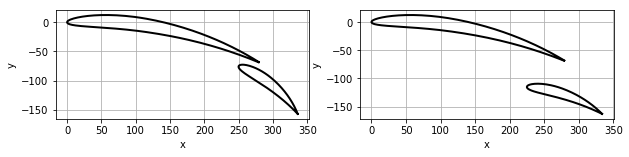

In [148]:
width = 10
py.figure(figsize=(width, width/5))
py.subplot(121)
py.grid()
py.xlabel('x')
py.ylabel('y')
py.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
py.plot(x_new1, y_new1, color='k', linestyle='-', linewidth=2)
py.subplot(122)
py.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
py.plot(x_new2, y_new2, color='k', linestyle='-', linewidth=2)
py.grid()
py.xlabel('x')
py.ylabel('y');

In [149]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
       
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [150]:
def define_panels(x, y, N):
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

In [151]:
class Freestream:
    
    def __init__(self, u_inf, alpha):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [152]:
def integral(x, y, panel, dxdz, dydz):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdz +
                (y - (panel.ya + np.cos(panel.beta) * s)) * dydz) /
               ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
               (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [153]:
#source contribution
def source_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [154]:
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [155]:
def kutta_condition(A_source, B_vortex):

    b = np.empty((2,A_source.shape[0]+2), dtype=float)
    A = np.empty((A_source.shape[0], A_source.shape[0]+2), dtype=float)
    
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
   
    b[0,:] = A[0, :] + A[N-1, :]
    b[1,:] = A[N, :] + A[-1, :]

    return b

In [156]:
def build_singularity_matrix(A_source, B_vortex):

    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = np.sum(B_vortex[:,:N], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:,N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex)


    return A

In [157]:
def build_freestream_rhs(panels, freestream):
   
    b = np.empty(panels.size+2,dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                              +np.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels[N].beta)
                              +np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [158]:
def get_velocity_field(panels, freestream, X, Y):
  
    # freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v

In [159]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [160]:
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [161]:
def iteration(panel, freestream):
    
    source = source_contribution_normal(panel)
    vortex = vortex_contribution_normal(panel)
    A = build_singularity_matrix(source, vortex)
    b = build_freestream_rhs(panel, freestream)

    sigma = np.linalg.solve(A, b)
    for i, panel in enumerate(panel):
        panel.sigma = sigma[i] 
    gamma = sigma[-2:]
    
    compute_tangential_velocity(panel, freestream, gamma, source, vortex)
    compute_pressure_coefficient(panel, freestream)
    
    return source, vortex, A, b, gamma

In [162]:
# define a mesh grid
nx, ny = 100,100  # number of points in the x and y directions
x_start, x_end = -50, 400
y_start, y_end = -200, 50
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

In [163]:
main = define_panels(x_main, y_main, N)
flap1 = define_panels(x_new1, y_new1, N)
flap2 = define_panels(x_new2, y_new2, N)
naca2408241510mm = np.append(main, flap1)
naca2408241550mm = np.append(main, flap2)
n = naca2408241510mm.size-1

freestream = Freestream(10, 0)

In [164]:
#1st Iteration - 10mm Gap
#source_241510mm, vortex_241510mm, A_241510mm, b_241510mm, gamma_241510mm = iteration(naca2408241510mm, freestream)

source_241510mm = source_contribution_normal(naca2408241510mm)
vortex_241510mm = vortex_contribution_normal(naca2408241510mm)
A_241510mm = build_singularity_matrix(source_241510mm, vortex_241510mm)
b_241510mm = build_freestream_rhs(naca2408241510mm, freestream)

sigma_241510mm = np.linalg.solve(A_241510mm, b_241510mm)
for i, panel in enumerate(naca2408241510mm):
    panel.sigma = sigma_241510mm[i] 
gamma_241510mm = sigma_241510mm[-2:]


#1st Iteration - 50mm Gap
source_241550mm = source_contribution_normal(naca2408241550mm)
vortex_241550mm = vortex_contribution_normal(naca2408241550mm)
A_241550mm = build_singularity_matrix(source_241550mm, vortex_241550mm)
b_241550mm = build_freestream_rhs(naca2408241550mm, freestream)

sigma_241550mm = np.linalg.solve(A_241550mm, b_241550mm)
for i, panel in enumerate(naca2408241550mm):
    panel.sigma = sigma_241550mm[i] 
gamma_241550mm = sigma_241550mm[-2:]

#TEST


In [165]:
compute_tangential_velocity(naca2408241510mm, freestream, gamma_241510mm, source_241510mm, vortex_241510mm)
compute_pressure_coefficient(naca2408241510mm, freestream)

compute_tangential_velocity(naca2408241550mm, freestream, gamma_241550mm, source_241550mm, vortex_241550mm)
compute_pressure_coefficient(naca2408241550mm, freestream)

In [166]:
# compute the velocity field on the mesh grid
u_241510mm, v_241510mm = get_velocity_field(naca2408241510mm, freestream, X, Y)
u_241550mm, v_241550mm = get_velocity_field(naca2408241550mm, freestream, X, Y)

cp_241510mm = 1.0 - (u_241510mm**2 + v_241510mm**2) / freestream.u_inf**2
cp_241550mm = 1.0 - (u_241550mm**2 + v_241550mm**2) / freestream.u_inf**2



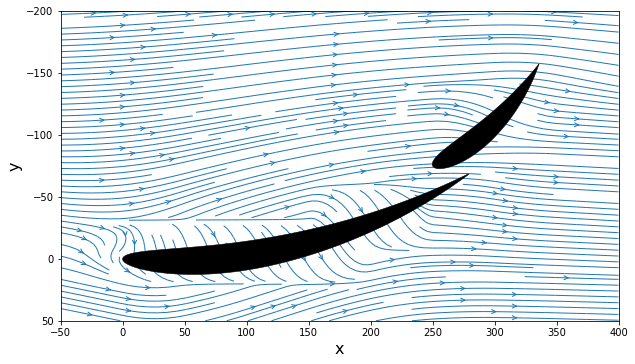

In [167]:
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.streamplot(X, Y, u_241510mm, v_241510mm,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.fill(x_new1,
            y_new1,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.gca().invert_yaxis();

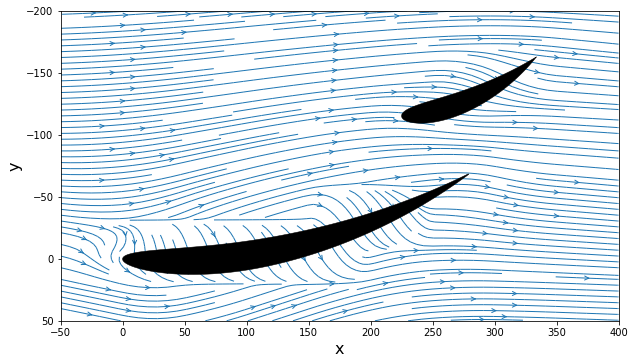

In [168]:
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.streamplot(X, Y, u_241550mm, v_241550mm,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.fill(x_new2,
            y_new2,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.gca().invert_yaxis();

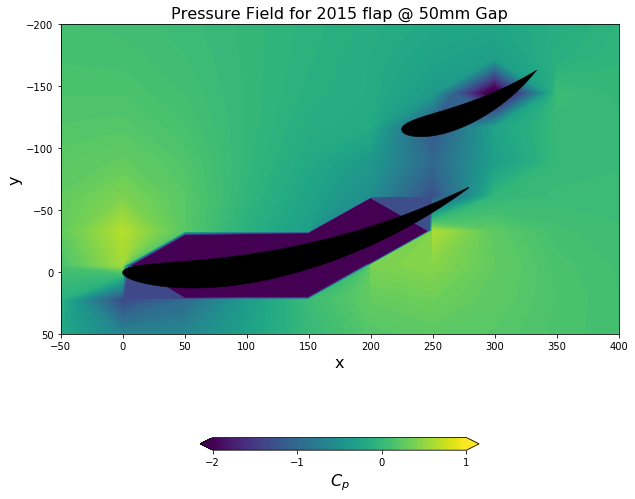

In [169]:
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
contf = py.contourf(X, Y, cp_241550mm,
                        levels=np.linspace(-2.0, 1.0, 100), extend='both')
cbar = py.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.fill(x_new2,
            y_new2,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Pressure Field for 2015 flap @ 50mm Gap', fontsize=16)
py.gca().invert_yaxis();

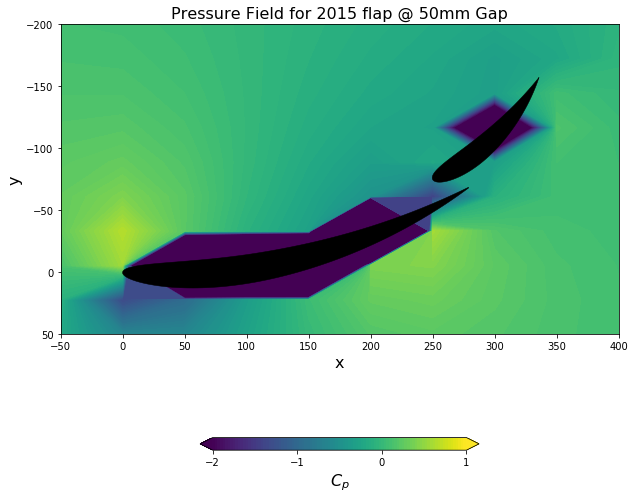

In [170]:
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
contf = py.contourf(X, Y, cp_241510mm,
                        levels=np.linspace(-2.0, 1.0, 100), extend='both')
cbar = py.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
py.fill(x_main,
            y_main,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.fill(x_new1,
            y_new1,
            color='k', linestyle='solid', linewidth=0.5, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Pressure Field for 2015 flap @ 50mm Gap', fontsize=16)
py.gca().invert_yaxis();